<a href="https://colab.research.google.com/github/hkhong72/big_data/blob/main/221101_1Kor_movice_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import json
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

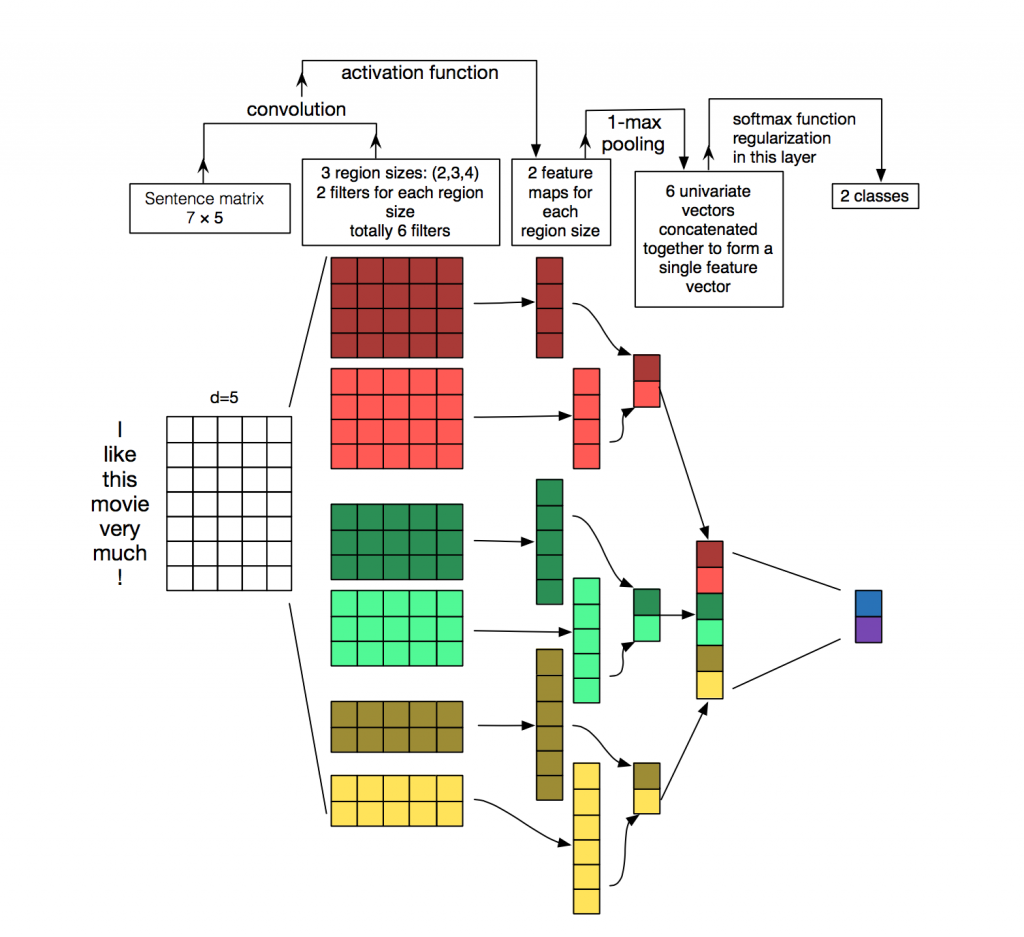

In [ ]:
# 슬랙에서 사진추가
Image("cnn-for-sentence.png")

In [ ]:
DATA_IN_PATH = 'data-in/'
DATA_OUT_PATH = 'data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs1.json'

In [ ]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [ ]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r', encoding="cp949"))

In [ ]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
        'vocab_size' : prepro_configs['vocab_size'],
        'embedding_size' : 128,
        'num_filters' : 100,
        'dropout_rate' : 0.5,
        'hidden_dim' : 250,
        'output_dim' : 1}

In [ ]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1,
                                         output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(kargs['num_filters'], kernel_size=kernel_size,
                                       padding='valid', activation='relu',
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                         for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(kargs['hidden_dim'], activation='relu',
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(kargs['output_dim'], activation='sigmoid',
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
model = CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3) # min_delta -> patience의 기준을 0.0001로 잡는다, 그동안 patience의 디폴트는 0
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5' # h5 -> 가중치만저장하는타입, 그동안은 hdf5
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
    
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True) #가중치만 저장함

In [ ]:
# 정답은 train_label
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                   callbacks=[early_stopping, checkpoint_callback])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.7759
Epoch 1: val_accuracy improved from -inf to 0.82293, saving model to data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 22s 79ms/step - loss: 0.4582 - accuracy: 0.7759 - val_loss: 0.3954 - val_accuracy: 0.8229
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8458
Epoch 2: val_accuracy improved from 0.82293 to 0.82833, saving model to data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 20s 78ms/step - loss: 0.3518 - accuracy: 0.8458 - val_loss: 0.3855 - val_accuracy: 0.8283
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.8729
Epoch 3: val_accuracy did not improve from 0.82833
264/264 [==============================] - 20s 78ms/step - loss: 0.3000 - accuracy: 0.8729 - val_loss: 0.3999 - val_accuracy: 0.8230
Epoch 4/10
264/264 [=========================

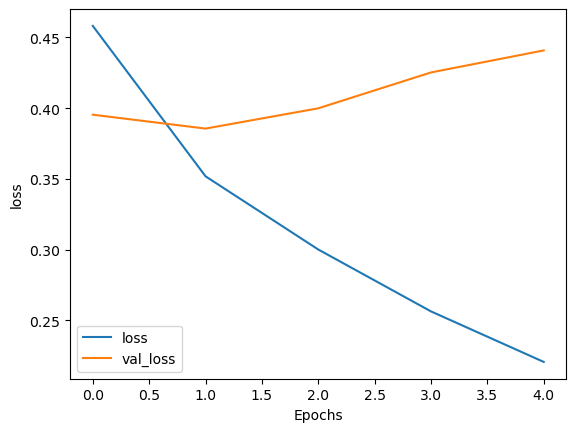

In [ ]:
plot_graphs(history, 'loss')

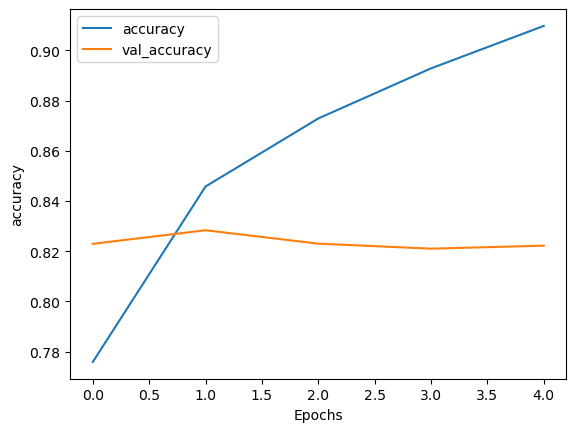

In [ ]:
plot_graphs(history, 'accuracy')